In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud

# %%


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('/Users/deepaksharma/Desktop/Open IIT DA/Dataset/drive-download-20221030T121228Z-001/text-and-id.txt') as inf:
    tdata = inf.read().split('\n')
res = []
for i in tdata:
    row = []
    text = ""
    num = ""
    flag = 0
    for j in i:
        if j.isdigit() and flag == 0:
            num+=j
        elif flag == 0:
            flag = 1
        else:
            text+=j
    row.append(num)
    row.append(text)
    res.append(row)
text_data = pd.DataFrame(res, columns=['Id', 'Text'])

# %%
with open('/Users/deepaksharma/Desktop/Open IIT DA/Dataset/drive-download-20221030T121228Z-001/pairs-label-training (1).txt') as inf:
    pdata = inf.read().split('\n')
list1 = []
for i in pdata:
    list1.append(i.split(', '))
pair_data = pd.DataFrame(list1, columns=['p1', 'p2', 'Output'])
pair_data, test_data = train_test_split(pair_data, test_size=0.2)



In [3]:
# Checking for Null values

print(text_data.isnull().sum())
print(pair_data.isnull().sum())

Id      0
Text    0
dtype: int64
p1        0
p2        0
Output    0
dtype: int64


(array([60455.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 64305.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

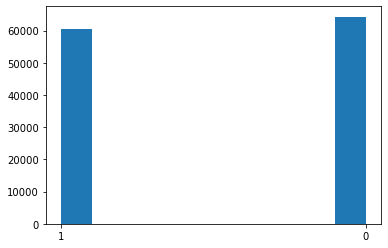

In [6]:
plt.hist(pair_data.Output)

([<matplotlib.patches.Wedge at 0x7fc0013163d0>,
 [Text(0.05330004621961892, 1.0987079252799565, '1'),
  Text(-0.05330004621961929, -1.0987079252799565, '0')])

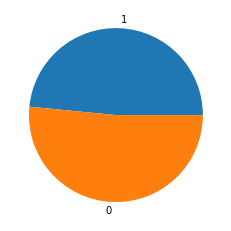

In [8]:
mylab=["1","0"]
plt.pie(np.array([60455, 64305]), labels=mylab)

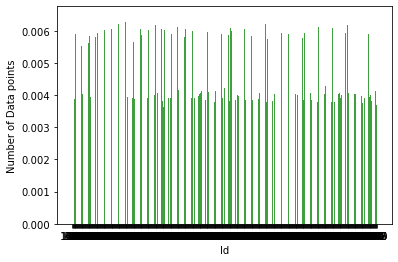

In [5]:
plt.hist(pair_data.p1, 2000, density=True, facecolor='g', alpha=0.75)
plt.xlabel("Id")
plt.ylabel("Number of Data points")
plt.show()


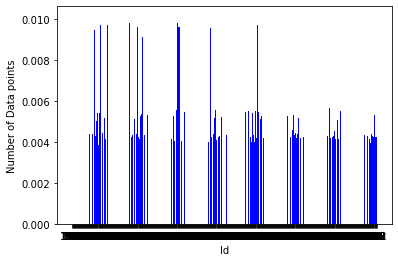

In [8]:
plt.hist(pair_data.p2, 2000, density=True, facecolor='b', alpha=1)
plt.xlabel("Id")
plt.ylabel("Number of Data points")
plt.show()

In [10]:
# %%
same_dict = {}
diff_dict = {}
arr = []
marked = []
for i in range(2000):
    same_dict[i] = []
    diff_dict[i] = []
    arr.append(-1)
    marked.append(0)

# %%
for i in range(pair_data.shape[0]):
    if pair_data.iloc[i,2] == "0":
        same_dict[int(pair_data.iloc[i,0])-1].append(int(pair_data.iloc[i,1])-1)
        same_dict[int(pair_data.iloc[i,1])-1].append(int(pair_data.iloc[i,0])-1)
        marked[int(pair_data.iloc[i,0])-1] = 1
        marked[int(pair_data.iloc[i,1])-1] = 1
    else:
        diff_dict[int(pair_data.iloc[i,0])-1].append(int(pair_data.iloc[i,1])-1)
        diff_dict[int(pair_data.iloc[i,1])-1].append(int(pair_data.iloc[i,0])-1)
        marked[int(pair_data.iloc[i,0])-1] = 1
        marked[int(pair_data.iloc[i,1])-1] = 1

In [17]:
def dfs(arr, same_dict, diff_dict, x, ind):
    if arr[ind] != -1:
        return
    arr[ind] = x
    for i in range(len(same_dict[ind])):
        dfs(arr, same_dict, diff_dict, x, same_dict[ind][i])
    for i in range(len(diff_dict[ind])):
        dfs(arr, same_dict, diff_dict, 1-x, diff_dict[ind][i])
for i in range(2000):
    if marked[i] == 1 and arr[i] == -1:
        dfs(arr, same_dict, diff_dict, 0, i)



In [18]:
import collections

In [40]:
'''Lemmatization is the process of grouping together the different 
inflected forms of a word so they can be analyzed as a single item'''


lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = [] # Contains all words of each sentence
    All_words = [] # Contains all words of entire dataset with duplicates
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        
        for i in new_item:
            All_words.append(i)
            
        corpus.append(' '.join(str(x) for x in new_item))
        
    All_words = [lm.lemmatize(word) for word in All_words if word not in set(stopwords.words('english'))]
    unique_words = set(All_words)
    #print(All_words)
    
    freq_words = [item for item, count in collections.Counter(All_words).items() if count > 20]
    print(freq_words)
    plt.figure(figsize=(100,15))
    #plt.hist(All_words)
    print(len(All_words))
    print(len(unique_words))
    print(len(freq_words))
    plt.show()
    
        
    return corpus, All_words, freq_words


In [41]:
corpus = []
All_words = []
freq_words = []
for i in range(2000):
    if marked[i] == 1:
        corpus.append(text_data[text_data["Id"] == str(i+1)].iloc[0, 1])
corpus, All_words, freq_words = text_transformation(corpus)


# %%
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = []
for i in range(2000):
    if marked[i] == 1:
        y.append(arr[i])


['man', 'made', 'land', 'mother', 'country', 'time', 'woman', 'person', 'year', 'men', 'new', 'good', 'one', 'make', 'change', 'soil', 'like', 'family', 'body', 'food', 'help', 'two', 'day', 'movement', 'way', 'part', 'used', 'also', 'plant', 'water', 'animal', 'use', 'people', 'work', 'example', 'girl', 'take', 'u', 'called', 'many', 'may', 'different', 'cell', 'energy', 'earth', 'need', 'right', 'due', 'activity', 'home', 'c', 'force', 'another', 'line', 'form', 'would', 'get', 'place', 'find', 'first', 'money', 'power', 'life', 'child', 'india', 'air', 'world', 'give', 'given', 'light']
13495
4376
70


<Figure size 7200x1080 with 0 Axes>

In [27]:
with open('/Users/deepaksharma/Desktop/Open IIT DA/Dataset/drive-download-20221030T121228Z-001/text-and-id.txt') as inf:
    text = inf.read()

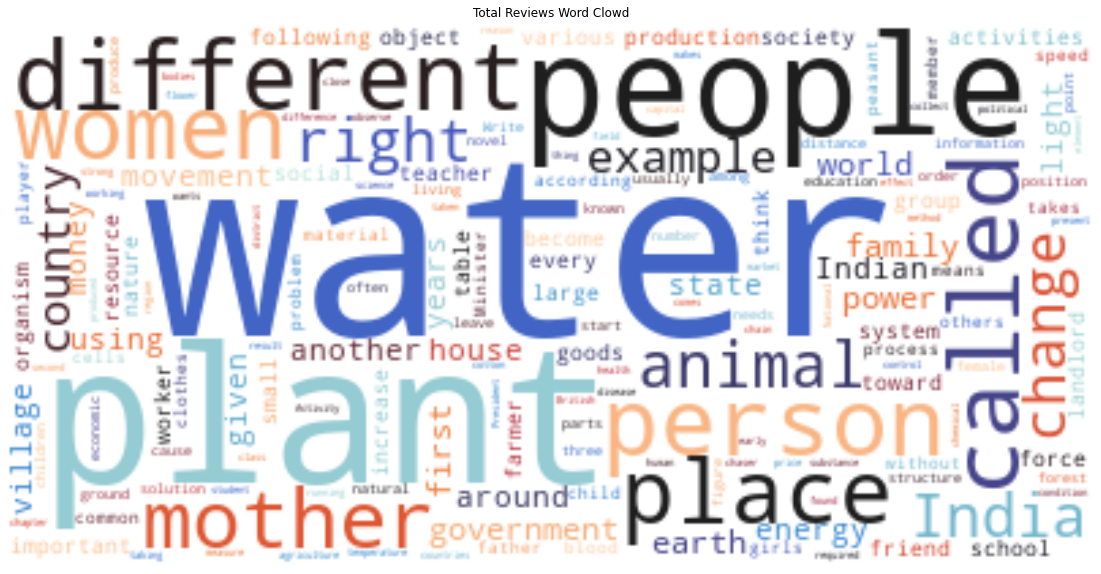

In [28]:
'''def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()'''

def generate_wordcloud(data, title):
    # Generate the image
    wordcloud = WordCloud(background_color="white", max_words=300, min_word_length=5, colormap="icefire").generate(data)
 
    # visualize the image
    fig=plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Total Reviews Word Clowd')
    plt.show()
    
generate_wordcloud(text, "Cloud")

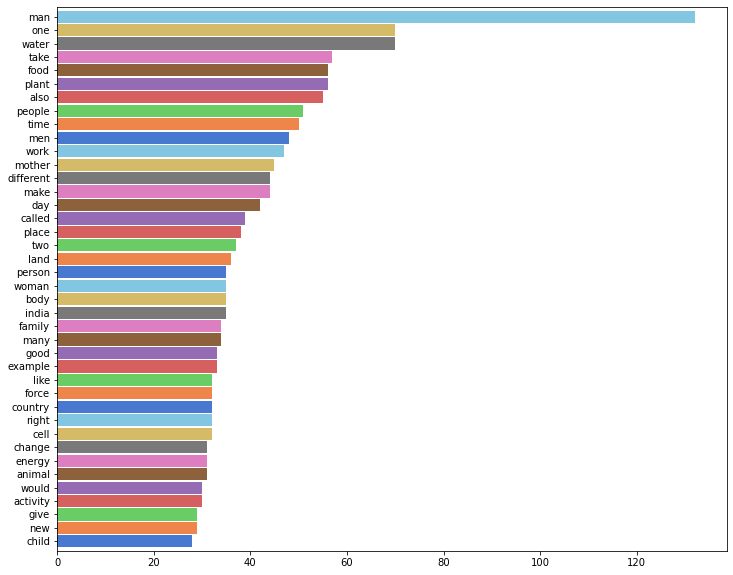

In [34]:
plt.subplots(figsize=(12,10))
list1=[]

for i in All_words:
    list1.extend(i)
    
ax = pd.Series(All_words).value_counts()[:40].sort_values(ascending=True).plot.barh(width=0.9, color=sns.color_palette('muted',40))

#for i,v in enumerate(pd.Series(list1).value_counts()[:40].sort_values(ascending = True).values):
#    ax.text(0.8, i, v, fontsize=12, color='white', weight='bold')

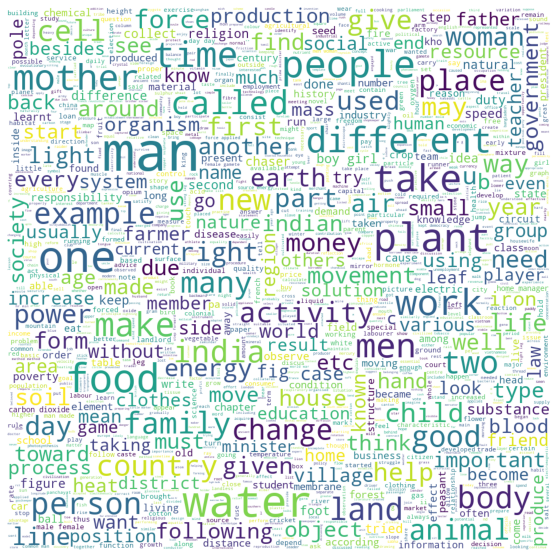

In [39]:
wc = WordCloud(background_color="white", max_words=2000, max_font_size= 100,width=1000,height=1000)
wc.generate(" ".join(All_words))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

/var/folders/b0/zgh9rxfx0lqc5ts31ggg2x_r0000gn/T/ipykernel_3431/1918161107.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  for i,v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values):


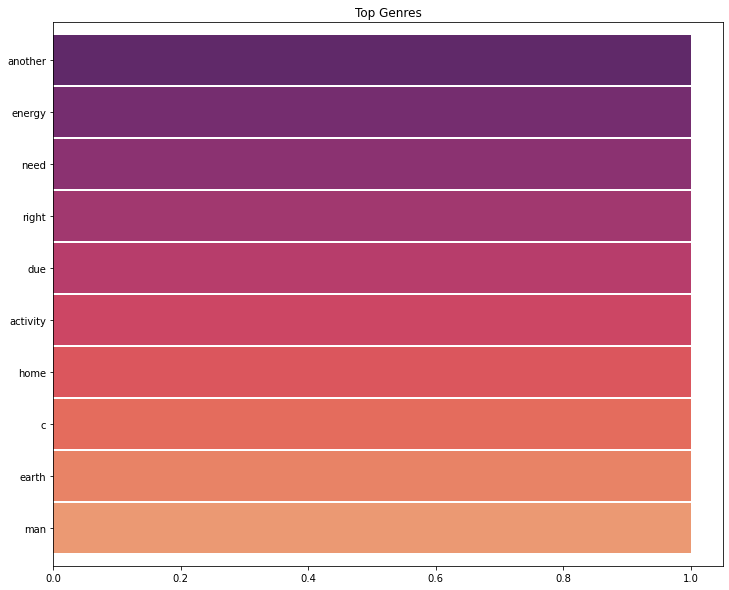

In [42]:
plt.subplots(figsize=(12,10))
list1=[]
    
ax = pd.Series(freq_words).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.95, color=sns.color_palette('flare',10))

for i,v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values):
    ax.text(0.8, i, v, fontsize=14, color='white', weight='bold')
plt.title('Top Genres')
plt.show()

In [29]:
# %%
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000, 1500],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}
grid_search = HalvingGridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16

HalvingGridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                    param_grid={'bootstrap': [True, False],
                                'max_depth': [5, 10, None],
                                'max_features': ('auto', 'sqrt'),
                                'min_samples_leaf': [1, 2, 5, 10],
                                'min_samples_split': [5, 10, 15],
                                'n_estimators': [500, 1000, 1500]})

In [30]:
# %%
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])
rfc.fit(X,y)



RandomForestClassifier(max_features='sqrt', min_samples_split=5,
                       n_estimators=500)

In [31]:
# %%
X_test_1, X_test_2 = [], []
for i in range(len(test_data)):
    X_test_1.append(text_data[text_data["Id"] == test_data.iloc[i, 0]].iloc[0, 1])
    X_test_2.append(text_data[text_data["Id"] == test_data.iloc[i, 1]].iloc[0, 1])
y_test = test_data.Output
test_corpus_1 = text_transformation(X_test_1)
testdata_1 = cv.transform(test_corpus_1)
predictions_1 = rfc.predict(testdata_1)
test_corpus_2 = text_transformation(X_test_2)
testdata_2 = cv.transform(test_corpus_2)
predictions_2 = rfc.predict(testdata_2)
predictions = []
for i in range(len(predictions_1)):
    if predictions_1[i] == predictions_2[i]:
        predictions.append('0')
    else:
        predictions.append('1')



In [32]:
# %%
acc_score = accuracy_score(y_test, predictions)
print('Accuracy_score: ',acc_score)

Accuracy_score:  0.9942932256099516
